In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np 
import sys
from sklearn.metrics import f1_score 
import seaborn as sns
from sklearn.utils.multiclass import unique_labels

## Read Data and normalize pitch/velocity

In [2]:
data = pd.read_csv('trevor_data.csv') 

# Normalize velocity and pitch values 
data['pitch'] = data['pitch'].apply(lambda x: x/(data['pitch'].max())) 
data['velocity'] = data['velocity'].apply(lambda x: x/(data['velocity'].max()))  

In [3]:
#function that takes two instrument datasets and generates a binary classification using
# a basic MLP
def gen_binary_model(instrument1, instrument2, style = "acoustic", verbosity = 2): 
    if verbosity > 0:
        print("Generating binary classification model for", instrument1, "and", instrument2) 
    # Extract data for first and second instrument 
    df_guitar = data[(data["instrument_family_str"] == instrument1) & (data["instrument_source_str"] == style)] 
    df_vocal = data[(data["instrument_family_str"] == instrument2) & (data["instrument_source_str"] == style)] 
    vocal_guitar_data = pd.concat([df_guitar, df_vocal])
    vocal_guitar_data = vocal_guitar_data.drop(['instrument_family_str', 'instrument_source_str'], axis=1) 
    raw_labels2 = np.asarray(list(vocal_guitar_data['instrument_family'])) 
    y2 = np.asarray([1 if x == raw_labels2.max() else 0 for x in raw_labels2]) 
    x2 = (vocal_guitar_data.drop(['instrument_family'], axis=1)).to_numpy() 
    x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.33, random_state=42) 
    
    # Create Model 
    model = models.Sequential()
    model.add(layers.Dense(12, activation='relu', input_dim=12)) 
    model.add(layers.Dense(6, activation='relu')) 
    model.add(layers.Dense(2, activation='sigmoid')) 
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']) 
    history = model.fit(x_train, y_train,batch_size=12, epochs=8, verbose = verbosity) 
    results = model.evaluate(x_test, y_test, batch_size=512, verbose = verbosity) 
    y_pred = model.predict_classes(x_test) 
    
#     f1 = f1_score(y_test, y_pred) 
    return results[1]

In [124]:
instruments = unique_labels(data["instrument_family_str"].iloc[:1000]) 
plot_data = []
for instrument1 in instruments:
    for instrument2 in instruments:
        accuracy = gen_binary_model(instrument1, instrument2, verbosity = 0) 
        plot_data.append([instrument1, accuracy]) 
        
df = pd.DataFrame(data, columns = instruments)

### Plot the results on a results matrix

In [46]:
df_matrix = np.zeros((10,10))
count = 0 
for x in range(0,10):
    for y in range(0,10):
        df_matrix[x,y] = plot_data[count][1]
        count +=1
        
matrix = pd.DataFrame(df_matrix, columns = instruments, index = instruments)
matrix

,bass,brass,flute,guitar,keyboard,mallet,organ,reed,string,vocal
bass,1.000000,0.984619,0.969067,0.983778,0.973250,0.993840,1.000000,0.985195,0.996752,1.000000
brass,0.981779,1.000000,0.776997,0.792825,0.714788,0.835138,0.986249,0.678049,0.806610,0.862203
flute,0.971837,0.781310,1.000000,0.835184,0.723646,0.845845,0.972196,0.712371,0.862219,0.841714
guitar,0.980900,0.788530,0.837575,1.000000,0.759115,0.806165,0.992396,0.827176,0.920433,0.956938
keyboard,0.969952,0.745420,0.720286,0.762699,1.000000,0.842964,0.988975,0.718883,0.847385,0.866718
mallet,0.992720,0.835138,0.853690,0.793169,0.843137,1.000000,0.994059,0.844813,0.910038,0.945575
organ,0.992000,0.984590,0.985171,0.992921,0.989710,0.994507,1.000000,0.993258,0.991172,0.954511
reed,0.984747,0.686820,0.710060,0.831963,0.724695,0.835383,0.986067,1.000000,0.746085,0.814402
string,0.998608,0.803675,0.857042,0.923289,0.849040,0.906238,0.990398,0.746641,1.000000,0.901044
vocal,1.000000,0.858513,0.854805,0.957137,0.874363,0.948341,0.955269,0.810863,0.898825,1.000000


In [136]:
new_matrix = matrix.drop(["bass", "organ"]).drop(columns = ["bass", "organ"])

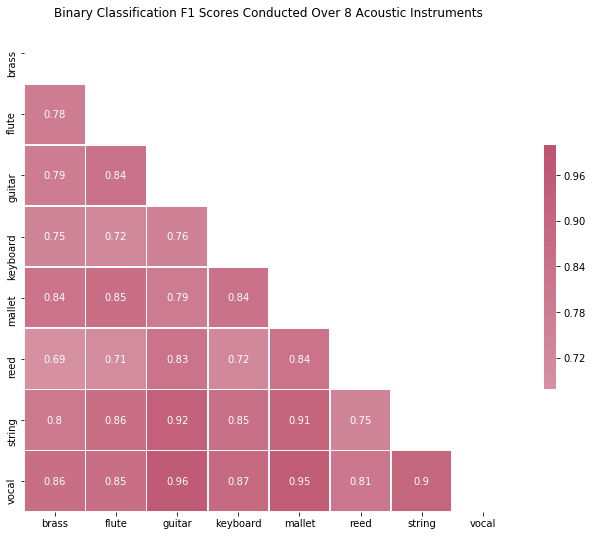

In [139]:
# Generate a mask for the upper triangle

mask = np.zeros_like(new_matrix)

mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(282, 359,52,50, sep=50,n =20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(new_matrix, mask= mask, vmax=1, center=0,
                square=True, linewidths=.7, cmap = cmap, cbar_kws={"shrink": 0.5}, annot = True, alpha = 10)
plt.title("Binary Classification F1 Scores Conducted Over 8 Acoustic Instruments")
plt.savefig("Binary_classification2.png", bbox_layout = "tight")
plt.show()